In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

# Configuration pour l'affichage
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('seaborn-v0_8-whitegrid')

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


# Partie 1 : Résolution simplifiée par Programmation Dynamique (Value Iteration)

On considère un cas simplifié avec :
- Un actif risqué et un actif sans risque (cash) ($r=0$).
- Objectif : Maximiser la capital terminale $B_T$.


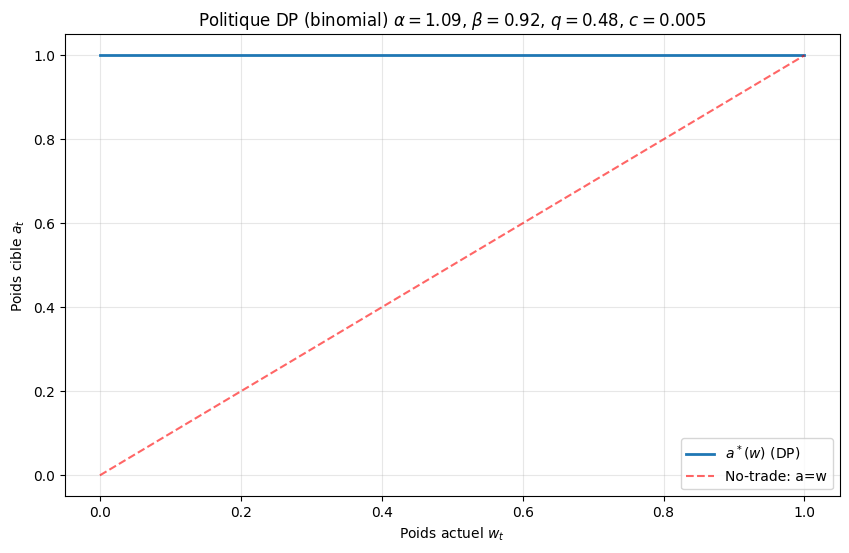

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


N_w = 101  # Grilles
W = np.linspace(0.0, 1.0, N_w)       # états w_t
A = np.linspace(0.0, 1.0, N_w)       # actions a_t 
T_horizon = 20  # Horizon temporel
gamma = 0.99  # Facteur d'actualisation

# Binomial price model
alpha = 1.09   # hausse
beta  = 0.92   # baisse
q = 0.48  # probabilite

# Coût de transaction 
c = 0.005

# Normalisation du capital 
B0 = 1.0

# V[t, i] = valeur à la date t quand w = W[i]
V = np.zeros((T_horizon + 1, N_w))
Policy = np.zeros((T_horizon, N_w))

# Condition terminale (Backward Induction) : V_T(w)=0 
V[T_horizon, :] = 0.0

def phi_1d(a, ratio):  # ratio = p'/p
    denom = a * ratio + (1 - a)
    return (a * ratio) / denom

for t in range(T_horizon - 1, -1, -1):  # start=T_horizon-1, stop=-1, step=-1
    for i, w in enumerate(W):

        best_val = -np.inf
        best_a = w  

        for a in A:
            cost_frac = c * abs(a - w)        
            B_after_cost = B0 * (1 - cost_frac)

            # 2) ratio_up = alpha, ratio_down = beta
            # 2a) Poids après évolution des prix : w' = phi(a, p, p')
            w_up = phi_1d(a, alpha)
            w_dn = phi_1d(a, beta)

            # 2b) Capital après évolution des prix
            # 1 actif risqué + cash
            # B' = B(1 - c|a-w|) * ( a*(p'/p) + (1-a)*1 )
            B_up = B_after_cost * (a * alpha + (1 - a))
            B_dn = B_after_cost * (a * beta  + (1 - a))

            # 3) Reward r
            r_up = B_up - B0
            r_dn = B_dn - B0

            # 4) Valeur future : V(t+1, w') via interpolation sur la grille W
            v_up = np.interp(w_up, W, V[t+1, :])
            v_dn = np.interp(w_dn, W, V[t+1, :])

            # 5) Bellman
            val = q * (r_up + gamma * v_up) + (1 - q) * (r_dn + gamma * v_dn)

            if val > best_val:
                best_val = val
                best_a = a

        V[t, i] = best_val
        Policy[t, i] = best_a

# Plot politique à t=0
plt.figure(figsize=(10,6))
plt.plot(W, Policy[0, :], lw=2, label=r"$a^*(w)$ (DP)")
plt.plot(W, W, "r--", alpha=0.6, label="No-trade: a=w")
plt.title(fr"Politique DP (binomial) $\alpha={alpha}$, $\beta={beta}$, $q={q}$, $c={c}$")
plt.xlabel(r"Poids actuel $w_t$")
plt.ylabel(r"Poids cible $a_t$")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


# Partie 2 : Apprentissage par Renforcement (PPO)

On passe maintenant au cas général (continu) avec un simulateur de marché.
L'environnement est défini selon le formalisme Gym :
- **Etat** : $[w_t, p_t, B_t]$ 
- **Action** : Allocation cible $a_t \in [0, 1]$
- **Récompense** : Variation de richesse nette $B_{t+1} - B_t$

Nous utilisons l'algorithme PPO (Proximal Policy Optimization) pour approximer la politique optimale $\pi_\theta$.

In [12]:
class TradingEnv(gym.Env):
    """
    Environnement d'allocation de portefeuille avec coûts de transaction.
    Modèle conforme à la section 4 du rapport.
    """
    def __init__(self):
        super(TradingEnv, self).__init__()
        
        # Paramètres de marché
        self.initial_capital = 100.0
        self.trans_cost = 0.001  # 0.1% de frais
        self.n_steps = 100      # Longueur épisode
        
        # Espace d'action : allocation cible a_t dans [0, 1]
        self.action_space = spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
        
        # Espace d'observation : [w_t, p_t (relatif), B_t (relatif)]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(3,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        self.capital = self.initial_capital
        self.w = 0.0    # Poids initial (tout en cash)
        self.price = 1.0
        self.t = 0
        
        return self._get_obs(), {}

    def _get_obs(self):
        # On normalise pour aider le réseau de neurones
        return np.array([self.w, self.price, self.capital/self.initial_capital], dtype=np.float32)

    def step(self, action):
        # 1. Action : Réallocation
        target_w = np.clip(action[0], 0, 1)
        
        # Coût de transaction : C_t = c * B_t * |a_t - w_t|
        cost = self.trans_cost * self.capital * np.abs(target_w - self.w)
        
        # Capital après frais
        net_capital = self.capital - cost
        
        # 2. Dynamique de marché (Mouvement Brownien Géométrique simplifié)
        # r_t ~ N(mu, sigma)
        ret = np.random.normal(0.01, 0.02) 
        self.price *= (1 + ret)
        
        # 3. Mise à jour Capital (B_{t+1})
        # B_{t+1} = B_{net} * (a * (1+r) + (1-a) * 1)  (Cash rapporte 0 ici pour simplifier)
        new_capital = net_capital * (target_w * (1 + ret) + (1 - target_w))
        
        # 4. Mise à jour Poids (w_{t+1}) - Dérive due aux prix
        if new_capital > 0:
            new_w = (target_w * (1 + ret) * net_capital) / new_capital
        else:
            new_w = 0
            
        # === CORRECTION ICI ===
        # Convertir numpy.float en float python standard
        reward = float(new_capital - self.capital)
        
        # Mise à jour état interne
        self.capital = new_capital
        self.w = new_w
        self.t += 1
        
        terminated = bool((self.t >= self.n_steps) or (self.capital <= 0))
        
        return self._get_obs(), reward, terminated, False, {}

# Vérification rapide de l'environnement
env = TradingEnv()
check_env(env)
print("Environnement Gym validé.")

Environnement Gym validé.


d:\Env_Varia\Lib\site-packages\stable_baselines3\common\env_checker.py:507: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [13]:
# Entraînement de l'agent PPO
print("Lancement de l'entraînement PPO...")

# Instanciation de l'environnement
env = TradingEnv()

# Modèle PPO avec hyperparamètres standards
# MlpPolicy : Réseau de neurones dense (pas de CNN)
model = PPO("MlpPolicy", env, verbose=1, learning_rate=0.0003)

# Entraînement (sur 20 000 pas pour l'exemple, augmenter pour meilleurs résultats)
model.learn(total_timesteps=20000)

print("Entraînement terminé.")

Lancement de l'entraînement PPO...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | 38.5     |
| time/              |          |
|    fps             | 1542     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | 37.1         |
| time/                   |              |
|    fps                  | 1156         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0076507516 |
|    clip_fraction        | 0.0935       |
|    clip_range

# Partie 3 : Résultats et Comparaison

On compare la stratégie apprise par l'agent PPO (RL) face à deux stratégies de référence (Benchmarks) :
1. **Buy and Hold** : On investit 50% au début et on ne touche plus à rien.
2. **Rebalancing Constant** : On réalloue à 50% à chaque pas de temps (coûteux en frais).

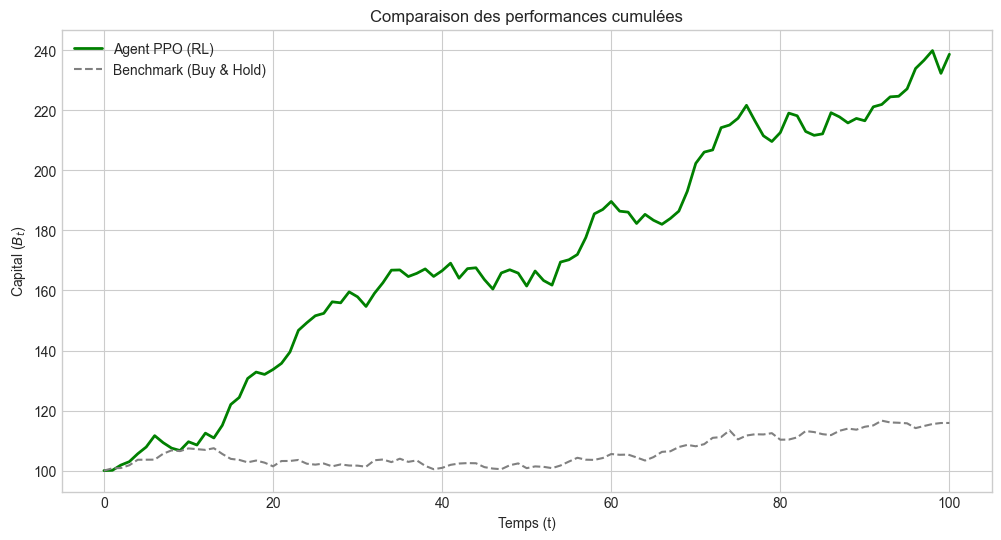

Capital Final PPO : 238.70
Capital Final B&H : 115.87


In [14]:
# Protocole de test
obs, _ = env.reset()
done = False
b_ppo = [env.capital]
costs_ppo = []

# 1. Simulation PPO
obs, _ = env.reset()
trajectory_ppo = []
capital_ppo = [env.initial_capital]

for _ in range(env.n_steps):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = env.step(action)
    capital_ppo.append(env.capital)
    if done: break

# 2. Simulation Benchmark (Buy and Hold 50%)
# On recrée l'environnement pour avoir la même seed si besoin, ou on simule manuellement
# Ici on simule une trajectoire "propre" pour comparer
np.random.seed(42) # Fixer l'aléa pour comparer les courbes sur les mêmes prix
prices = [100]
for _ in range(env.n_steps):
    prices.append(prices[-1] * (1 + np.random.normal(0.005, 0.02)))

# Calcul B&H (50/50 initial)
cap_bh = [100]
shares = 50 / 100 # 50 cash, 50 en actif (au prix 100)
cash = 50
for p in prices[1:]:
    cap_bh.append(cash + shares * p)

# Affichage des résultats
t_axis = np.arange(len(capital_ppo))

plt.figure(figsize=(12, 6))
plt.plot(capital_ppo, label='Agent PPO (RL)', color='green', linewidth=2)
plt.plot(cap_bh[:len(capital_ppo)], label='Benchmark (Buy & Hold)', color='gray', linestyle='--')

plt.title("Comparaison des performances cumulées")
plt.xlabel("Temps (t)")
plt.ylabel("Capital ($B_t$)")
plt.legend()
plt.show()

print(f"Capital Final PPO : {capital_ppo[-1]:.2f}")
print(f"Capital Final B&H : {cap_bh[len(capital_ppo)-1]:.2f}")